**一、项目背景介绍**

车牌检测识别常用于智能或无人车辆管理系统等，应用场景广泛。希望通过更加个性化的算法定制，使之适用于更为丰富的生活场景。

**二、数据介绍**

1.数据集准备

In [4]:
#解压到work文件夹下
!unzip -oq /home/aistudio/data/data120711/CCPD2020.zip -d work/

In [5]:
#查看目录结构
!tree work/ -d

work/
└── CCPD2020
    └── ccpd_green
        ├── test
        ├── train
        └── val

5 directories


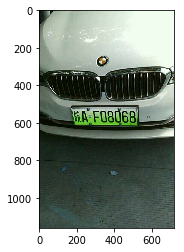

In [6]:
#抽样可视化
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow(cv2.imread("work/CCPD2020/ccpd_green/test/03320043103448276-90_257-175&525_526&611-526&611_191&608_175&528_522&525-0_0_5_24_32_24_30_32-118-219.jpg"))

2.数据转化,生成数据列表

In [ ]:
import os, cv2
import random
words_list = [
    "A", "B", "C", "D", "E",
    "F", "G", "H", "J", "K", 
    "L", "M", "N", "P", "Q", 
    "R", "S", "T", "U", "V", 
    "W", "X", "Y", "Z", "0", 
    "1", "2", "3", "4", "5", 
    "6", "7", "8", "9" ]

con_list = [
    "皖", "沪", "津", "渝", "冀",
    "晋", "蒙", "辽", "吉", "黑",
    "苏", "浙", "京", "闽", "赣",
    "鲁", "豫", "鄂", "湘", "粤",
    "桂", "琼", "川", "贵", "云",
    "西", "陕", "甘", "青", "宁",
    "新"]

count = 0
total = []
# E:\Paddle\PaddleOCR-release-2.1\work\CCPD
paths = os.listdir('E:\Paddle\PaddleOCR-release-2.1\work\CCPD')
for path in paths:
    for item in os.listdir(os.path.join('E:\Paddle\PaddleOCR-release-2.1\work\CCPD', path)):
        new_path = os.path.join(path, item)
        _, _, bbox, points, label, _, _ = item.split('-')
        points = points.split('_')
        points = [_.split('&') for _ in points]
        tmp = points[-2:]+points[:2]
        points = []
        for point in tmp:
            points.append([int(_) for _ in point])
        label = label.split('_')
        con = con_list[int(label[0])]
        words = [words_list[int(_)] for _ in label[1:]]
        label = con+''.join(words)
        line = new_path+'\t'+'[{"transcription": "%s", "points": %s}]' % (' ', str(points))
        line = line[:]+'\n'
        total.append(line)
        print(len(total))

random.shuffle(total)

with open('E:\Paddle\PaddleOCR-release-2.1\work\\train.txt', 'w', encoding='UTF-8') as f:
    for line in total[:-1431]:
        f.write(line)

with open('E:\Paddle\PaddleOCR-release-2.1\work\dev.txt', 'w', encoding='UTF-8') as f:
    for line in total[-1431:]:
        f.write(line)



**三、模型介绍**

模型选择

选定DBNet+RARE作为本次项目使用的模型，两个模型均使用MobileNetV3作为其主干网络(Backbone)

3.下载检测和识别预训练模型

In [ ]:
#检测预训练模型
https://paddle-imagenet-models-name.bj.bcebos.com/MobileNetV3_large_x0_5_pretrained.tar

#识别推理模型
https://paddleocr.bj.bcebos.com/dygraph_v2.0/ch/ch_ppocr_server_v2.0_rec_infer.tar

**四、模型训练**

4.检测模型训练

In [ ]:
python tools/train.py -c det.yml

In [ ]:
#det.yml文件
Global:
  use_gpu: true
  epoch_num: 5
  log_smooth_window: 20
  print_batch_step: 10
  save_model_dir: output/det_vlpr/
  save_epoch_step: 1
  eval_batch_step: [1000, 1000]
  load_static_weights: True
  cal_metric_during_train: False
  pretrained_model: pretrain_models/MobileNetV3_large_x0_5_pretrained
  checkpoints:
  save_inference_dir: inference/det_vlpr
  use_visualdl: False
  infer_img: doc/imgs_en/img_10.jpg
  save_res_path: output/det_vlpr/predicts.txt

Architecture:
  model_type: det
  algorithm: DB
  Transform:
  Backbone:
    name: MobileNetV3
    scale: 0.5
    model_name: large
    disable_se: True
  Neck:
    name: DBFPN
    out_channels: 96
  Head:
    name: DBHead
    k: 50

Loss:
  name: DBLoss
  balance_loss: true
  main_loss_type: DiceLoss
  alpha: 5
  beta: 10
  ohem_ratio: 3

Optimizer:
  name: Adam
  beta1: 0.9
  beta2: 0.999
  lr:
    name: Cosine
    learning_rate: 0.001
    warmup_epoch: 1
  regularizer:
    name: 'L2'
    factor: 0

PostProcess:
  name: DBPostProcess
  thresh: 0.3
  box_thresh: 0.6
  max_candidates: 1000
  unclip_ratio: 1.5

Metric:
  name: DetMetric
  main_indicator: hmean

Train:
  dataset:
    name: SimpleDataSet
    data_dir: CCPD
    label_file_list:
      - CCPD/train.txt
    ratio_list: [1.0]
    transforms:
      - DecodeImage: # load image
          img_mode: BGR
          channel_first: False
      - DetLabelEncode: # Class handling label
      - IaaAugment:
          augmenter_args:
            - { 'type': Fliplr, 'args': { 'p': 0.5 } }
            - { 'type': Affine, 'args': { 'rotate': [-10, 10] } }
            - { 'type': Resize, 'args': { 'size': [0.5, 3] } }
      - EastRandomCropData:
          size: [960, 960]
          max_tries: 50
          keep_ratio: true
      - MakeBorderMap:
          shrink_ratio: 0.4
          thresh_min: 0.3
          thresh_max: 0.7
      - MakeShrinkMap:
          shrink_ratio: 0.4
          min_text_size: 8
      - NormalizeImage:
          scale: 1./255.
          mean: [0.485, 0.456, 0.406]
          std: [0.229, 0.224, 0.225]
          order: 'hwc'
      - ToCHWImage:
      - KeepKeys:
          keep_keys: ['image', 'threshold_map', 'threshold_mask', 'shrink_map', 'shrink_mask'] # the order of the dataloader list
  loader:
    shuffle: True
    drop_last: False
    batch_size_per_card: 32
    num_workers: 0

Eval:
  dataset:
    name: SimpleDataSet
    data_dir: CCPD
    label_file_list:
      - CCPD/dev.txt
    transforms:
      - DecodeImage: # load image
          img_mode: BGR
          channel_first: False
      - DetLabelEncode: # Class handling label
      - DetResizeForTest:
      - NormalizeImage:
          scale: 1./255.
          mean: [0.485, 0.456, 0.406]
          std: [0.229, 0.224, 0.225]
          order: 'hwc'
      - ToCHWImage:
      - KeepKeys:
          keep_keys: ['image', 'shape', 'polys', 'ignore_tags']
  loader:
    shuffle: False
    drop_last: False
    batch_size_per_card: 1 # must be 1
    num_workers: 0


**五、模型评估**

5.模型测试和模型导出

In [ ]:
# 模型测试
python tools/infer_det.py -c det_vlpr.yml -o Global.infer_img=test0.jpg Global.pretrained_model=output/det_vlpr/best_accuracy Global.load_static_weights=False

# 模型导出
python tools/export_model.py -c output/det_vlpr/config.yml -o Global.pretrained_model=output/det_vlpr/best_accuracy Global.load_static_weights=False Global.save_inference_dir=./inference/det_vlpr


**六、总结与升华**

在项目实践过程中，仍有一些识别不出或者识别错误的情况发生，尤其针对于模糊的图像，还需要改进，以期达到更理想的状态。

**七、个人总结**

一枚无名小卒，无甚紧要的在校生，还很迷茫。

[无关紧要的链接](http://aistudio.baidu.com/aistudio/usercenter)

In [ ]:
# 查看当前挂载的数据集目录, 该目录下的变更重启环境后会自动还原
# View dataset directory. 
# This directory will be recovered automatically after resetting environment. 
!ls /home/aistudio/data

In [ ]:
# 查看工作区文件, 该目录下的变更将会持久保存. 请及时清理不必要的文件, 避免加载过慢.
# View personal work directory. 
# All changes under this directory will be kept even after reset. 
# Please clean unnecessary files in time to speed up environment loading. 
!ls /home/aistudio/work

In [ ]:
# 如果需要进行持久化安装, 需要使用持久化路径, 如下方代码示例:
# If a persistence installation is required, 
# you need to use the persistence path as the following: 
!mkdir /home/aistudio/external-libraries
!pip install beautifulsoup4 -t /home/aistudio/external-libraries

In [ ]:
# 同时添加如下代码, 这样每次环境(kernel)启动的时候只要运行下方代码即可: 
# Also add the following code, 
# so that every time the environment (kernel) starts, 
# just run the following code: 
import sys 
sys.path.append('/home/aistudio/external-libraries')

请点击[此处](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576)查看本环境基本用法.  <br>
Please click [here ](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576) for more detailed instructions. 